# SV2TTS Tacotron-2 single-speaker fine-tuning

The main advantage of the `SV2TTS` is that it allows really fast training on single-speaker with few data.

This notebook shows how to fine-tune a pretrained `multi-speaker SV2TTS` on `single-speaker` based on an `identification dataset`.

Note : the `SV2TTS` initial objective is to be a *universal voice cloner* but in practice I did not achieve this kind of performance yet. However with this notebook, I achieved to train completely realistic `TTS` model with only 20min of annotated audio (around 450 samples) !

## Imports + model creation

In [2]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from models.tts import SV2TTSTacotron2, WaveGlow
from custom_architectures import get_architecture
from datasets import get_dataset, train_test_split, filter_dataset
from utils import plot_spectrogram, select_embedding
from utils.text import default_french_encoder
from utils.audio import display_audio, load_audio, write_audio, embed_annotation_dataset

gpus = tf.config.list_physical_devices('GPU')

rate = 22050
model_name = 'sv2tts_fine_tuned'

print("Tensorflow version : {}".format(tf.__version__))
print("Available GPU's : {}".format(gpus))

Tensorflow version : 2.10.0
Available GPU's : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
model = SV2TTSTacotron2.from_pretrained(pretrained_name = 'sv2tts_tacotron2_256', nom = model_name)
print(model)

Model restoration...
Initializing submodel : tts_model !
Optimizer 'tts_model_optimizer' initilized successfully !
Submodel tts_model compiled !
  Loss : {'reduction': 'none', 'name': 'tacotron_loss', 'mel_loss': 'mse', 'mask_mel_padding': True, 'label_smoothing': 0, 'finish_weight': 1.0, 'not_finish_weight': 1.0, 'from_logits': False}
  Optimizer : {'name': 'Adam', 'learning_rate': {'class_name': 'WarmupScheduler', 'config': {'factor': 1024.0, 'warmup_steps': 2048, 'minval': 0.00025, 'maxval': 0.00075}}, 'decay': 0.0, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'epsilon': 1e-07, 'amsgrad': False}
  Metrics : []
Successfully restored tts_model from pretrained_models/sv2tts_tacotron2_256/saving/tts_model.json !
Model sv2tts_tacotron2_256 initialized successfully !
Initializing submodel : tts_model !
Submodel tts_model saved in pretrained_models\sv2tts_fine_tuned\saving\tts_model.json !
Model sv2tts_fine_tuned initialized successfully !
Weights transfered successfully !
S

## Model initialization

In [2]:
model = SV2TTSTacotron2(nom = model_name)

lr = 5e-4 #{ 'name': 'WarmupScheduler', 'maxval' : 5e-4, 'minval' : 25e-5, 'factor' : 256, 'warmup_steps' : 256}

model.compile(optimizer = 'rmsprop', optimizer_config = {'lr' : lr})

print(model)

Model restoration...
Initializing submodel : tts_model !
Optimizer 'tts_model_optimizer' initilized successfully !
Submodel tts_model compiled !
  Loss : {'reduction': 'none', 'name': 'tacotron_loss', 'mel_loss': 'mse', 'mask_mel_padding': True, 'label_smoothing': 0, 'finish_weight': 1.0, 'not_finish_weight': 1.0, 'from_logits': False}
  Optimizer : {'name': 'RMSprop', 'learning_rate': 0.0005000000237487257, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
  Metrics : []
Successfully restored tts_model from pretrained_models/sv2tts_fine_tuned/saving/tts_model.json !
Model sv2tts_fine_tuned initialized successfully !
Model tts_model is already compiled !

========== sv2tts_fine_tuned ==========
Sub model tts_model
- Inputs 	: unknown
- Outputs 	: unknown
- Number of layers 	: 3
- Number of parameters 	: 30.341 Millions
- Optimizer 	: {'name': 'RMSprop', 'learning_rate': 0.0005000000237487257, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentu

## Dataset creation / loading

In [ ]:
path = 'D:/datasets/...'

dataset = embed_annotation_dataset(
    path, embed_fn = model.speaker_encoder.embed, embedding_dim = model.embedding_dim, rate = model.speaker_encoder.audio_rate,
    embedding_name = 'embeddings_256_mel_lstm.csv'
)


In [3]:
kwargs = {
    'directory'      : 'D:/datasets/...',
    'type_annots'    : 'identification',
    'embedding_dim'  : model.speaker_embedding_dim,
    'embedding_name' : 'embeddings_256_mel_lstm.csv'
}

dataset = get_dataset(
    'custom_dataset_name', ds_type = 'custom', ** kwargs
)
dataset.pop('indexes')

print("Dataset length : {} ({} speakers)".format(
    len(dataset), len(dataset['id'].unique())
))

Loading dataset custom_dataset...
Dataset length : 489 (1 speakers)


## Training

In [4]:
epochs          = [25] * 4
batch_size      = 16
valid_batch_size    = batch_size

max_valid_size  = min(int(0.05 * len(dataset)), 256 * valid_batch_size)

train_size      = min(1024 * batch_size, len(dataset) - max_valid_size)
valid_size      = min(len(dataset) - train_size, max_valid_size)

shuffle_size    = 1024
pred_step       = -5

""" Custom training hparams """
augment_prct        = 0.2
augment_speaker_embedding   = False

trim_audio      = True
reduce_noise    = False
trim_threshold  = 0.025
max_silence     = 0.1
trim_method     = 'remove'
trim_mode       = 'start_end'

trim_mel     = False
trim_factor  = 0.6
trim_mel_method  = 'max_start_end'

# Seems to be interesting for single-speaker fine-tuning
# and for a better generalization but seems to slow down convergence 
use_utterance_embedding = True

max_input_length = 300
max_output_length = 2048

""" Training """

train, valid = train_test_split(
    dataset, train_size = train_size, valid_size = valid_size, shuffle = True
)

print("Training samples   : {} - {} batches - {} speakers".format(
    len(train), len(train) // batch_size, len(train['id'].unique())
))
print("Validation samples : {} - {} batches - {} speakers".format(
    len(valid), len(valid) // valid_batch_size, len(valid['id'].unique())
))

if not isinstance(epochs, list): epochs = [epochs]

# This feature seems interesting for singl-speaker fine-tuning
# If you want to enable it, put `trainable = False`
for epoch_i in range(epochs):
    trainable = False
    if model.epochs >= 75:
        model.tts_model.postnet.trainable = False
    if model.epochs >= 25:
        model.tts_model.encoder.trainable = False
    if model.epochs >= 175:
        model.tts_model.postnet.trainable = True

    model.train(
        train, validation_data = valid, 
        epochs = epoch_i, batch_size = batch_size, valid_batch_size = valid_batch_size,

        max_input_length = max_input_length, max_output_length = max_output_length,
        shuffle_size = shuffle_size, pred_step = pred_step,
        augment_prct = augment_prct, augment_speaker_embedding = augment_speaker_embedding,

        trim_audio = trim_audio, reduce_noise = reduce_noise, trim_threshold = trim_threshold,
        max_silence = max_silence, trim_method = trim_method, trim_mode = trim_mode,

        trim_mel = trim_mel, trim_factor = trim_factor, trim_mel_method = trim_mel_method,

        use_utterance_embedding = use_utterance_embedding
    )



Training samples   : 465 - 29 batches - 1 speakers
Validation samples : 24 - 1 batches - 1 speakers
Training config :
HParams :
- augment_prct	: 0.2
- max_input_length	: 300
- max_output_length	: 2048
- max_train_frames	: -1
- pad_to_multiple	: False
- trim_audio	: True
- reduce_noise	: False
- trim_threshold	: 0.025
- max_silence	: 0.1
- trim_method	: remove
- trim_mode	: start_end
- trim_mel	: False
- trim_factor	: 0.6
- trim_mel_method	: max_start_end
- augment_speaker_embedding	: False
- use_utterance_embedding	: True
- epochs	: 200
- batch_size	: 16
- valid_batch_size	: 16
- test_batch_size	: 1
- verbose	: 1
- train_times	: 1
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -5
- shuffle_size	: 1024

Epoch 176/200
30/30 [==============================] - 182s 6s/step - loss: 0.2314 - mse_mel_loss: 0.1216 - mse_mel_postnet_loss: 0.1088 - gate_loss: 9.4628e-04 - val_loss: 1.1254 - val_mse_mel_loss: 0.6053 - val_mse_mel_postnet_loss: 0.5055 - val

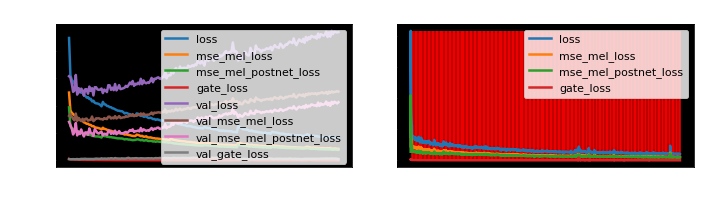

===== History =====
     gate_loss      loss  mse_mel_loss  mse_mel_postnet_loss  val_gate_loss  \
0     0.014255  1.115848      0.618151              0.483441       0.011125   
1     0.009353  0.776747      0.456221              0.311174       0.010080   
2     0.008799  0.736094      0.433986              0.293309       0.010603   
3     0.008098  0.717322      0.422392              0.286832       0.011174   
4     0.007525  0.698487      0.410769              0.280194       0.010260   
5     0.007291  0.680808      0.400190              0.273327       0.010765   
6     0.006749  0.656811      0.386646              0.263416       0.012367   
7     0.006065  0.656248      0.384379              0.265805       0.010172   
8     0.005919  0.630934      0.369394              0.255621       0.011123   
9     0.005935  0.618028      0.361547              0.250546       0.013825   
10    0.005460  0.616480      0.359966              0.251053       0.013055   
11    0.005088  0.593968      0.

In [5]:
model.plot_history()
print(model.history)

## Complete inference

These cells allow you to test your model with a complete inference pipeline

In [2]:
waveglow = WaveGlow()
model    = SV2TTSTacotron2(nom = model_name)

Model restoration...
Initializing submodel : vocoder !
Successfully restored vocoder from pretrained_models/pretrained_waveglow/saving/vocoder.json !
Model pretrained_waveglow initialized successfully !
Model restoration...
Initializing submodel : tts_model !
Optimizer 'tts_model_optimizer' initilized successfully !
Submodel tts_model compiled !
  Loss : {'reduction': 'none', 'name': 'tacotron_loss', 'mel_loss': 'mse', 'mask_mel_padding': True, 'label_smoothing': 0, 'finish_weight': 1.0, 'not_finish_weight': 1.0, 'from_logits': False}
  Optimizer : {'name': 'RMSprop', 'learning_rate': 0.0005000000237487257, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
  Metrics : []
Successfully restored tts_model from pretrained_models/sv2tts_fine_tuned/saving/tts_model.json !
Model sv2tts_fine_tuned initialized successfully !


In [3]:
def full_inference(text, embedding, n = 1):
    encoded = tf.expand_dims(model.encode_text(text), axis = 0)
    
    _, mel, _, attn = model.infer(
        encoded, [tf.shape(encoded)[1]], embedding
    )
    
    mel = np.squeeze(mel, 0)
    
    plot_spectrogram(inference = mel, attention = attn)
    audio = np.squeeze(waveglow.infer(mel))

    display_audio(audio, rate = rate)
    return audio

kwargs = {
    'directory'      : 'D:/datasets/...',
    'type_annots'    : 'identification',
    'embedding_dim'  : model.speaker_embedding_dim,
    'embedding_name' : 'embeddings_256_mel_lstm.csv'
}

dataset = get_dataset(
    'custom_dataset_name', ds_type = 'custom', ** kwargs
)
dataset.pop('indexes')

Loading dataset custom_dataset...


In [ ]:
text = "Bonjour à tous ! J'espère que vous allez aimer cette démonstration de voix en français !"

x = random.randrange(0, len(dataset))
print("Selected embedding : {}".format(x))

display_audio(dataset.iloc[x]['filename'])
embedding = select_embedding(dataset, mode = x)


silence = np.zeros((int(rate * 0.15),))
audios = []
if not isinstance(text, list): text = [text]

for p in text:
    for _ in range(1):
        audio = full_inference(p, embedding)
    audios.append(audio)
    audios.append(silence)
    #write_audio(audio = audio.numpy(), filename = 'example_outputs/audio_test.mp3')

if len(text) > 1:
    audios = np.concatenate(audios)
    _ = display_audio(audios, rate)

In [20]:
# To set the 1st embedding as the default one (the one used when calling `predict`)
model.set_default_embeddings(dataset.iloc[0 : 1])

## Test game

This cell will create 8 audios : 4 *true* (copy from the dataset) and 4 *false* (generated by your model. The objective is to distinguish *fake* than *real* audios !

In [ ]:
indexes = [2, 3, 5, 7] # indexes for the fake audios
embedding = select_embedding(ds, mode = 0)

dataset = filter_dataset(ds, duree = lambda d: d >= 1)
for i in range(len(indexes) * 2):
    x = random.randrange(len(dataset))
    print("Selected x for index {} : {} (fake : {})".format(i, x, i in indexes))
    if i in indexes:
        text = dataset.iloc[x]['text']
        audio = full_inference(text, embedding)
    else:
        audio = load_audio(dataset.iloc[x]['filename'], rate)
    display_audio(audio, rate = rate)
    write_audio(audio, 'game/audio/audio_{}.mp3'.format(i))


## Waveglow inference on training generated audios

This is a demonstration on prediction at step 500 so it is normal that inference is so bad ;)

In [ ]:
def infer_with_target(model_name, step, n, mode, save = False, display = True):
    if mode == 'train':
        directory = os.path.join('pretrained_models', model_name, 'training-logs', 'eval', 'mels')
        filename = 'pred_step-{:06d}_{}_target.npy'.format(step, n)
        pred_filename = 'pred_step-{:06d}_{}_pred.npy'.format(step, n)
        infer_filename = 'pred_step-{:06d}_{}_infer.npy'.format(step, n)
    else:
        directory = os.path.join('pretrained_models', model_name, 'outputs', 'mels')
        filename = 'pred_{}_target.npy'.format(n)
        pred_filename = 'pred_{}_pred.npy'.format(n)
        infer_filename = 'pred_{}_infer.npy'.format(n)

    if not os.path.exists(os.path.join(directory, filename)): return
    
    target = np.load(os.path.join(directory, filename))
    pred   = np.load(os.path.join(directory, pred_filename))
    infer  = np.load(os.path.join(directory, infer_filename))
    
    audio       = waveglow.infer(target)
    audio_pred  = waveglow.infer(pred)
    audio_infer = waveglow.infer(infer)

    _ = display_audio(audio, rate = rate)
    _ = display_audio(audio_pred, rate = rate)
    _ = display_audio(audio_infer, rate = rate)
    
    if save:
        save_dir = directory.replace('mels', 'audios')
        os.makedirs(save_dir, exist_ok = True)
        write_audio(audio, os.path.join(save_dir, filename[:-3] + 'mp3'), rate = rate)
        write_audio(audio_pred, os.path.join(save_dir, pred_filename[:-3] + 'mp3'), rate = rate)
        write_audio(audio_infer, os.path.join(save_dir, infer_filename[:-3] + 'mp3'), rate = rate)
    
    plot_spectrogram(
        target = target, prediction = pred, inference = infer
    )

waveglow = get_architecture('nvidia_waveglow')

In [ ]:
step, mode = 500, 'train'

for n in range(5):
    infer_with_target(model_name, step, n, mode)


## Tests

In [ ]:
from custom_train_objects.optimizers import WarmupScheduler

lr = WarmupScheduler(maxval = 75e-5, minval = 25e-5, factor = 1024)
print(lr.get_config())
lr.plot(1024 * 10)